In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import os,sys,inspect

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

import ipywidgets as widgets
from IPython.display import display

import yfinance as yf
from pandas_datareader import data as web

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
from trade.configuration import Configuration
etfs = Configuration().etfs()

In [4]:
data = yf.download(etfs, period="ytd")

[*********************100%***********************]  30 of 30 completed


In [5]:
data

Adj Close                                                         \
                CIBR      EWC      EWY     FDIS       FDN     FLJP      FTC   
Date                                                                          
2021-01-04  43.54000 30.94000 88.32000 70.65000 210.22000 29.39500 95.32000   
2021-01-05  43.67000 31.52000 90.53000 71.45000 211.87000 29.64000 96.35000   
2021-01-06  43.21000 31.81000 90.40000 72.29000 208.09000 30.05000 95.95000   
2021-01-07  44.35000 32.15000 92.10000 73.52000 213.27000 29.97400 98.83000   
2021-01-08  44.97000 32.11000 96.22000 74.62000 215.96001 30.52000 99.82000   

                                       ...     Volume                  \
                FXC     GQRE     HDEF  ...        SPY     VCR     VGT   
Date                                   ...                              
2021-01-04 76.92000 56.35000 23.38000  ...  110210800  166700  810100   
2021-01-05 77.61000 56.68000 23.53000  ...   66426200  134000  446000   
2021-01-06 77.65000 56.77000 24.01000  ...  107997700  118900  780700   
2021-01-07 77.61000 56.45000 24.05000  ...   68766800  134600  558400   
2021-01-08 77.45000 56.86000 24.16000  ...   71630100  168300  539600   

                                                                       
               VLUE      VPL      XBI   XITK    XMLV      XRT     XSD  
Date                                                                   
2021-01-04  1057400  1031100  7149300  41400  355900  3460400  668800  
2021-01-05   907000   427600  4499400  11100  267100  2278000  394100  
2021-01-06  3376200  3223900  6561500  91000  340500  5117800  234800  
2021-01-07   870800  2139900  4321300  36900  178600  1949800  172700  
2021-01-08   841400   759600  4230000  32200  437800  2309000  115100  

[5 rows x 180 columns]

In [6]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [7]:
returns = data["Close"].pct_change().dropna()

In [8]:
dataframes = pd.DataFrame()
for stock in etfs:
   dataframes[stock] = data['Adj Close'][stock]

In [9]:
mu = expected_returns.return_model(dataframes, method="capm_return")

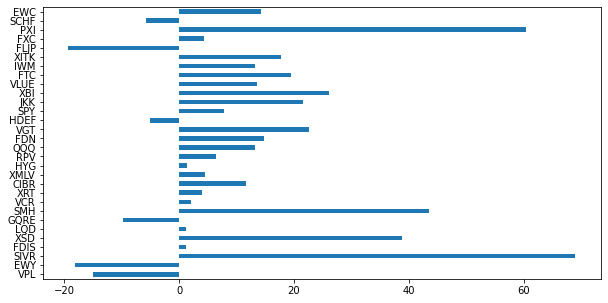

In [10]:
mu.plot.barh(figsize=(10,5));

In [13]:
# # Optional (filter by std quatile, not the fixed number)
# mu = mu.where(mu > 6).dropna()
# etfs_by_return = mu.index.to_numpy()
# print(mu)
# fdataframes = dataframes[etfs_by_return]
S = risk_models.risk_matrix(dataframes, method="oracle_approximating")
# mu = expected_returns.return_model(fdataframes, method="capm_return")
fdataframes = dataframes

In [14]:
ef = EfficientFrontier(mu, S)

In [15]:
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

In [16]:
ef.portfolio_performance(verbose=True)

Expected annual return: 3346.7%
Annual volatility: 11.3%
Sharpe Ratio: 294.95


(33.46706440600465, 0.11340075390447256, 294.9456970469531)

In [17]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(cleaned_weights, fdataframes.iloc[-1], total_portfolio_value=7500)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
pd.Series(alloc).sort_index()

Leftover: $3.44


CIBR     6
EWC      6
FDIS     1
FDN      1
FTC      4
FXC      1
HYG      1
IWM      1
JKK      1
PXI     39
QQQ      1
RPV      2
SIVR    43
SMH      4
VGT      1
VLUE     3
XBI      4
XITK     2
XMLV     1
XSD      4
dtype: int64